# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, \
                                          num_workers = 12)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, \
                                         num_workers = 12)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [5]:
ps[0]

tensor([0.1037, 0.0871, 0.1016, 0.1019, 0.1036, 0.0973, 0.1012, 0.1111, 0.0990,
        0.0936], grad_fn=<SelectBackward>)

In [6]:
torch.sum(ps[0])

tensor(1.0000, grad_fn=<SumBackward0>)

With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [7]:
top_p, top_class = ps.topk(1, dim=1)

In [8]:
print(top_p[:10,:])

tensor([[0.1111],
        [0.1103],
        [0.1103],
        [0.1090],
        [0.1076],
        [0.1103],
        [0.1115],
        [0.1075],
        [0.1088],
        [0.1095]], grad_fn=<SliceBackward>)


In [9]:
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7]])


Check the labels.

In [10]:
len(labels)

64

In [11]:
labels[:10]

tensor([7, 7, 3, 3, 3, 0, 8, 8, 5, 8])

Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [12]:
top_class.shape

torch.Size([64, 1])

We will use `top_class.shape` instead of `*top_class.shape`. The asterisk is to keep the tuple (refer to [this](https://stackoverflow.com/questions/400739/what-does-asterisk-mean-in-python)).

In [13]:
equals = top_class == labels.view(top_class.shape)

In [14]:
equals[:10]

tensor([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.uint8)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [15]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [16]:
model = Classifier()
model = nn.DataParallel(model, device_ids=[0])

criterion = nn.NLLLoss()
criterion = nn.DataParallel(criterion, device_ids=[0])

optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_loss_epochs = []
test_loss_epochs = []
for e in range(epochs):
    tic = time.time()
    
    train_losses = []
    test_losses = []
    for images, labels in trainloader:
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        # Forward and backward propagations
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        # Calculate train accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(1-accuracy)
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        # turn off gradients
        # Calculate test accuracy with gradient calculation off
        with torch.no_grad():
            # validation pass here
            for images, labels in testloader:
                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
                test_losses.append(1-accuracy)

    toc = time.time()
    print("epoch %2d, runtime %6.3f seconds" % (e + 1, toc - tic))
    train_loss_epoch = torch.mean(torch.tensor(train_losses))
    train_loss_epochs.append(train_loss_epoch.item())
    #bar print("    Training loss   : %5.2f" % train_loss_epoch)
    test_loss_epoch = torch.mean(torch.tensor(test_losses))
    test_loss_epochs.append(test_loss_epoch.item())
    #bar print("    Validation loss : %5.2f" % test_loss_epoch)

epoch  1, runtime  6.341 seconds
epoch  2, runtime  7.479 seconds
epoch  3, runtime  7.874 seconds
epoch  4, runtime  7.709 seconds
epoch  5, runtime  9.173 seconds
epoch  6, runtime  9.065 seconds
epoch  7, runtime  8.473 seconds
epoch  8, runtime  9.239 seconds
epoch  9, runtime  9.084 seconds
epoch 10, runtime  9.776 seconds
epoch 11, runtime  9.210 seconds
epoch 12, runtime  9.915 seconds
epoch 13, runtime  9.432 seconds
epoch 14, runtime  9.176 seconds
epoch 15, runtime  9.148 seconds
epoch 16, runtime  9.560 seconds
epoch 17, runtime  9.069 seconds
epoch 18, runtime 10.349 seconds
epoch 19, runtime 10.118 seconds
epoch 20, runtime  9.753 seconds
epoch 21, runtime  9.864 seconds
epoch 22, runtime  9.750 seconds
epoch 23, runtime 10.295 seconds
epoch 24, runtime 10.703 seconds
epoch 25, runtime 11.117 seconds
epoch 26, runtime 11.600 seconds
epoch 27, runtime 11.065 seconds
epoch 28, runtime 10.821 seconds
epoch 29, runtime 11.198 seconds
epoch 30, runtime 10.559 seconds


CPU runtime:
```
epoch  1, runtime  7.735 seconds
epoch  2, runtime  9.293 seconds
epoch  3, runtime  8.857 seconds
epoch  4, runtime  8.158 seconds
epoch  5, runtime  9.461 seconds
epoch  6, runtime  9.997 seconds
epoch  7, runtime 10.285 seconds
epoch  8, runtime 10.003 seconds
epoch  9, runtime 10.595 seconds
epoch 10, runtime 10.127 seconds
epoch 11, runtime 10.630 seconds
epoch 12, runtime 11.668 seconds
epoch 13, runtime 12.156 seconds
epoch 14, runtime 12.197 seconds
epoch 15, runtime 11.198 seconds
epoch 16, runtime 11.119 seconds
epoch 17, runtime 11.664 seconds
epoch 18, runtime 12.423 seconds
epoch 19, runtime 12.746 seconds
epoch 20, runtime 12.867 seconds
epoch 21, runtime 12.898 seconds
epoch 22, runtime 12.913 seconds
epoch 23, runtime 12.847 seconds
epoch 24, runtime 13.072 seconds
epoch 25, runtime 13.124 seconds
epoch 26, runtime 12.768 seconds
epoch 27, runtime 12.983 seconds
epoch 28, runtime 13.231 seconds
epoch 29, runtime 13.435 seconds
epoch 30, runtime 12.914 seconds
```

GPU runtime:
```
epoch  1, runtime  6.341 seconds
epoch  2, runtime  7.479 seconds
epoch  3, runtime  7.874 seconds
epoch  4, runtime  7.709 seconds
epoch  5, runtime  9.173 seconds
epoch  6, runtime  9.065 seconds
epoch  7, runtime  8.473 seconds
epoch  8, runtime  9.239 seconds
epoch  9, runtime  9.084 seconds
epoch 10, runtime  9.776 seconds
epoch 11, runtime  9.210 seconds
epoch 12, runtime  9.915 seconds
epoch 13, runtime  9.432 seconds
epoch 14, runtime  9.176 seconds
epoch 15, runtime  9.148 seconds
epoch 16, runtime  9.560 seconds
epoch 17, runtime  9.069 seconds
epoch 18, runtime 10.349 seconds
epoch 19, runtime 10.118 seconds
epoch 20, runtime  9.753 seconds
epoch 21, runtime  9.864 seconds
epoch 22, runtime  9.750 seconds
epoch 23, runtime 10.295 seconds
epoch 24, runtime 10.703 seconds
epoch 25, runtime 11.117 seconds
epoch 26, runtime 11.600 seconds
epoch 27, runtime 11.065 seconds
epoch 28, runtime 10.821 seconds
epoch 29, runtime 11.198 seconds
epoch 30, runtime 10.559 seconds
```

In [17]:
train_loss_epochs

[0.18395189940929413,
 0.14342351257801056,
 0.13019722700119019,
 0.12311767041683197,
 0.11743737012147903,
 0.1107909083366394,
 0.1082589253783226,
 0.10374467074871063,
 0.10106276720762253,
 0.09818097203969955,
 0.09743136912584305,
 0.09335021674633026,
 0.09046841412782669,
 0.08853611350059509,
 0.08825293183326721,
 0.08525452762842178,
 0.08298907428979874,
 0.08150652796030045,
 0.08054038137197495,
 0.07987406849861145,
 0.07705890387296677,
 0.07650919258594513,
 0.07466018199920654,
 0.07394389808177948,
 0.0723947212100029,
 0.07116204500198364,
 0.06907982379198074,
 0.06916311383247375,
 0.06689765304327011,
 0.0676305964589119]

In [18]:
test_loss_epochs

[0.16092754900455475,
 0.15067675709724426,
 0.15017913281917572,
 0.13614650070667267,
 0.14530254900455475,
 0.13156847655773163,
 0.12529855966567993,
 0.13097134232521057,
 0.12619426846504211,
 0.11833200603723526,
 0.1197253167629242,
 0.1259952187538147,
 0.11723726242780685,
 0.12261146306991577,
 0.1302746832370758,
 0.1271894872188568,
 0.11942674964666367,
 0.11723726242780685,
 0.11843153089284897,
 0.11415206640958786,
 0.11723726242780685,
 0.12679140269756317,
 0.11733677983283997,
 0.11803343892097473,
 0.12440286576747894,
 0.11514729261398315,
 0.11275875568389893,
 0.12052149325609207,
 0.11415206640958786,
 0.11922770738601685]

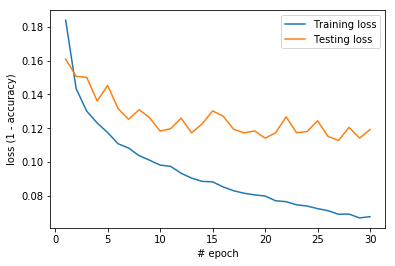

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

y = [i+1 for i in range(epochs)]
ax1.plot(y, train_loss_epochs, label='Training loss')
ax1.plot(y, test_loss_epochs, label='Testing loss')
plt.legend(loc='upper right');

plt.ylabel('loss (1 - accuracy)')
plt.xlabel('# epoch')
plt.show()

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [30]:
## TODO: Define your model with dropout added
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [31]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = Classifier()
model = nn.DataParallel(model, device_ids=[0])

criterion = nn.NLLLoss()
criterion = nn.DataParallel(criterion, device_ids=[0])

optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_loss_epochs = []
test_loss_epochs = []
for e in range(epochs):
    tic = time.time()
    
    train_losses = []
    test_losses = []
    # set model back to train mode
    model.train()
    for images, labels in trainloader:
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        # Forward and backward propagations
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        # Calculate train accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(1-accuracy)
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        # turn off gradients
        # Calculate test accuracy with gradient calculation off
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            # validation pass here
            for images, labels in testloader:
                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
                test_losses.append(1-accuracy)

    toc = time.time()
    print("epoch %2d, runtime %6.3f seconds" % (e + 1, toc - tic))
    train_loss_epoch = torch.mean(torch.tensor(train_losses))
    train_loss_epochs.append(train_loss_epoch.item())
    #bar print("    Training loss   : %5.2f" % train_loss_epoch)
    test_loss_epoch = torch.mean(torch.tensor(test_losses))
    test_loss_epochs.append(test_loss_epoch.item())
    #bar print("    Validation loss : %5.2f" % test_loss_epoch)

epoch  1, runtime  6.614 seconds
epoch  2, runtime  8.514 seconds
epoch  3, runtime  9.279 seconds
epoch  4, runtime  8.600 seconds
epoch  5, runtime  8.857 seconds
epoch  6, runtime  9.680 seconds
epoch  7, runtime 10.158 seconds
epoch  8, runtime 11.228 seconds
epoch  9, runtime 11.042 seconds
epoch 10, runtime 11.727 seconds
epoch 11, runtime 12.195 seconds
epoch 12, runtime 12.045 seconds
epoch 13, runtime  9.920 seconds
epoch 14, runtime 10.298 seconds
epoch 15, runtime 10.679 seconds
epoch 16, runtime 11.694 seconds
epoch 17, runtime 11.455 seconds
epoch 18, runtime 11.397 seconds
epoch 19, runtime 11.820 seconds
epoch 20, runtime 11.780 seconds
epoch 21, runtime 11.258 seconds
epoch 22, runtime 11.350 seconds
epoch 23, runtime 11.785 seconds
epoch 24, runtime 11.872 seconds
epoch 25, runtime 11.993 seconds
epoch 26, runtime 11.706 seconds
epoch 27, runtime 12.107 seconds
epoch 28, runtime 12.417 seconds
epoch 29, runtime 11.741 seconds
epoch 30, runtime 12.224 seconds


GPU runtime:
```
epoch  1, runtime  6.614 seconds
epoch  2, runtime  8.514 seconds
epoch  3, runtime  9.279 seconds
epoch  4, runtime  8.600 seconds
epoch  5, runtime  8.857 seconds
epoch  6, runtime  9.680 seconds
epoch  7, runtime 10.158 seconds
epoch  8, runtime 11.228 seconds
epoch  9, runtime 11.042 seconds
epoch 10, runtime 11.727 seconds
epoch 11, runtime 12.195 seconds
epoch 12, runtime 12.045 seconds
epoch 13, runtime  9.920 seconds
epoch 14, runtime 10.298 seconds
epoch 15, runtime 10.679 seconds
epoch 16, runtime 11.694 seconds
epoch 17, runtime 11.455 seconds
epoch 18, runtime 11.397 seconds
epoch 19, runtime 11.820 seconds
epoch 20, runtime 11.780 seconds
epoch 21, runtime 11.258 seconds
epoch 22, runtime 11.350 seconds
epoch 23, runtime 11.785 seconds
epoch 24, runtime 11.872 seconds
epoch 25, runtime 11.993 seconds
epoch 26, runtime 11.706 seconds
epoch 27, runtime 12.107 seconds
epoch 28, runtime 12.417 seconds
epoch 29, runtime 11.741 seconds
epoch 30, runtime 12.224 seconds
```

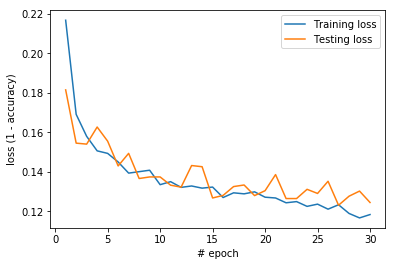

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

y = [i+1 for i in range(epochs)]
ax1.plot(y, train_loss_epochs, label='Training loss')
ax1.plot(y, test_loss_epochs, label='Testing loss')
plt.legend(loc='upper right');

plt.ylabel('loss (1 - accuracy)')
plt.xlabel('# epoch')
plt.show()

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

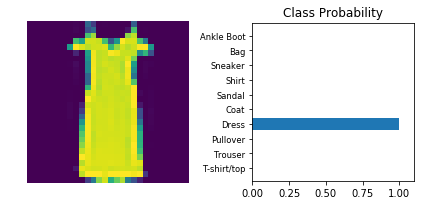

Process Process-1531:
Process Process-1530:
Process Process-1535:
Process Process-1532:
Process Process-1534:
Process Process-1526:
Process Process-1529:
Process Process-1533:
Process Process-1536:
Process Process-1525:
Process Process-1528:
Traceback (most recent call last):
Process Process-1527:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()

  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/eka/anaconda3/envs/deep-learning/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
 

In [39]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.